In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bigmart-sales-data/Train.csv
/kaggle/input/bigmart-sales-data/Test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("/kaggle/input/bigmart-sales-data/Train.csv")
test = pd.read_csv("/kaggle/input/bigmart-sales-data/Test.csv")
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
test['Item_Outlet_Sales'] = np.nan
data = pd.concat([train, test], ignore_index=True)

Train Shape: (8523, 12)
Test Shape: (5681, 11)


In [4]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
14199,FDB58,10.50,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN
14200,FDD47,7.60,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN
14201,NCO17,10.00,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN
14202,FDJ26,15.30,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN


In [5]:
print(data.isnull().sum())

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64


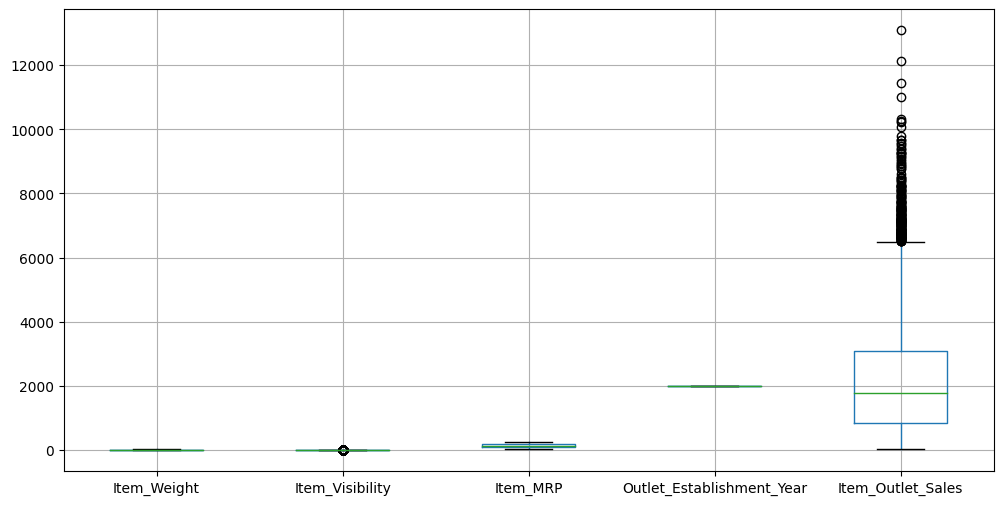

In [6]:
data.boxplot(figsize=(12, 6))
plt.show()

In [7]:

data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)


In [8]:
data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)


In [9]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

In [10]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
14199,FDB58,10.50,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN
14200,FDD47,7.60,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN
14201,NCO17,10.00,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,Medium,Tier 2,Supermarket Type1,NaN
14202,FDJ26,15.30,Regular,0.000000,Canned,214.6218,OUT017,2007,Medium,Tier 2,Supermarket Type1,NaN


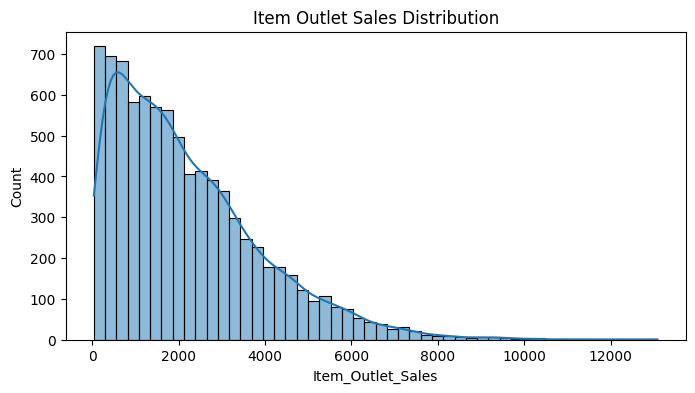

In [11]:
# ================================
# 4. Exploratory Data Analysis (EDA)
# ================================

# Sales distribution
plt.figure(figsize=(8,4))
sns.histplot(train['Item_Outlet_Sales'], bins=50, kde=True)
plt.title("Item Outlet Sales Distribution")
plt.show()




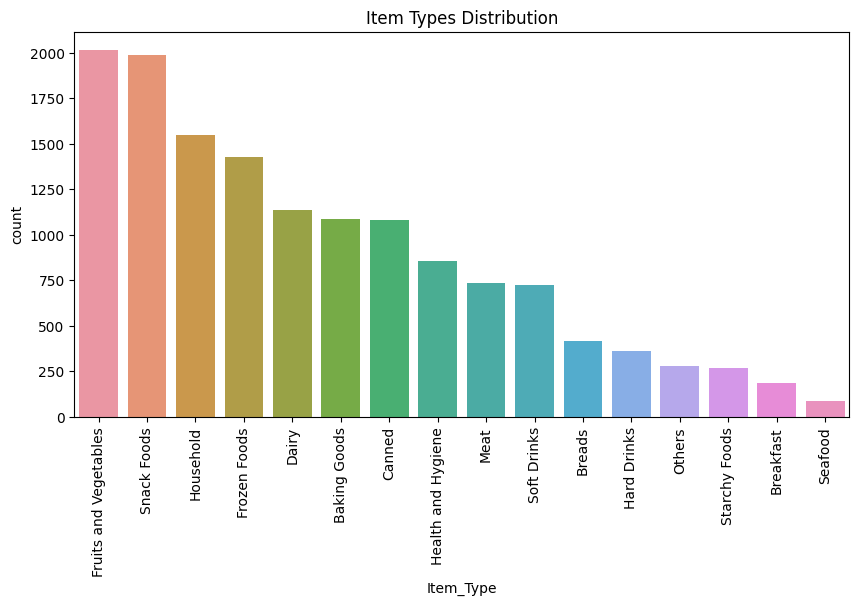

In [12]:
# Item Type Count
plt.figure(figsize=(10,5))
sns.countplot(x="Item_Type", data=data, order=data['Item_Type'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Item Types Distribution")
plt.show()



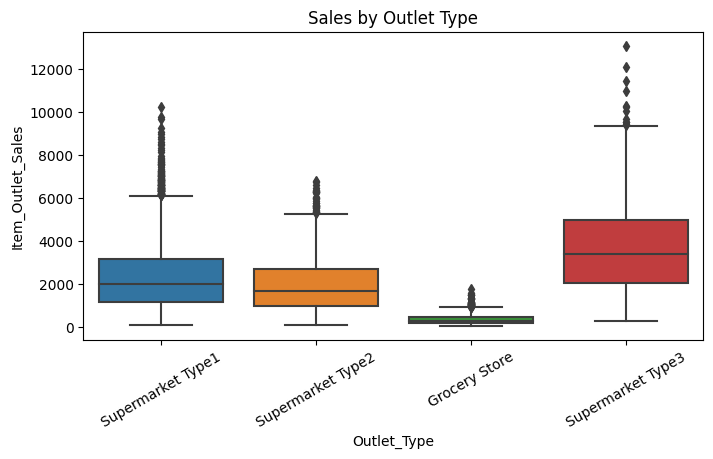

In [13]:
# Sales by Outlet Type
plt.figure(figsize=(8,4))
sns.boxplot(x="Outlet_Type", y="Item_Outlet_Sales", data=train)
plt.xticks(rotation=30)
plt.title("Sales by Outlet Type")
plt.show()

In [14]:
data['Outlet_Age'] = 2025 - data['Outlet_Establishment_Year']
data['Item_Category'] = data['Item_Identifier'].str[:2]
data['Item_Category'] = data['Item_Category'].map({'FD': 'Food',
                                                   'NC': 'Non-Consumable',
                                                   'DR': 'Drinks'})
data.loc[data['Item_Category']=='Non-Consumable', 'Item_Fat_Content'] = "Non-Edible"
data.drop(["Item_Identifier","Outlet_Establishment_Year"], axis=1, inplace=True)


In [15]:
data

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Category
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,26,Food
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,16,Drinks
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,26,Food
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,27,Food
4,8.93,Non-Edible,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,38,Non-Consumable
...,...,...,...,...,...,...,...,...,...,...,...,...
14199,10.50,Regular,0.013496,Snack Foods,141.3154,OUT046,Small,Tier 1,Supermarket Type1,NaN,28,Food
14200,7.60,Regular,0.142991,Starchy Foods,169.1448,OUT018,Medium,Tier 3,Supermarket Type2,NaN,16,Food
14201,10.00,Non-Edible,0.073529,Health and Hygiene,118.7440,OUT045,Medium,Tier 2,Supermarket Type1,NaN,23,Non-Consumable
14202,15.30,Regular,0.000000,Canned,214.6218,OUT017,Medium,Tier 2,Supermarket Type1,NaN,18,Food


In [16]:
le = LabelEncoder()
cat_cols = ['Item_Fat_Content','Item_Type','Outlet_Identifier',
            'Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Category']

for col in cat_cols:
    data[col] = le.fit_transform(data[col])

In [17]:
train = data[~data['Item_Outlet_Sales'].isnull()]
test = data[data['Item_Outlet_Sales'].isnull()].drop('Item_Outlet_Sales', axis=1)
X = train.drop("Item_Outlet_Sales", axis=1)
y = train["Item_Outlet_Sales"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("Random Forest Performance:")
print("MAE:", mean_absolute_error(y_val, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("R2:", r2_score(y_val, y_pred_rf))


Random Forest Performance:
MAE: 754.8848912868034
RMSE: 1079.9077450231925
R2: 0.5709295138732924


In [19]:
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

print("\nXGBoost Performance:")
print("MAE:", mean_absolute_error(y_val, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("R2:", r2_score(y_val, y_pred_xgb))


XGBoost Performance:
MAE: 805.5782413927325
RMSE: 1145.4410816576024
R2: 0.5172738332684677


In [20]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 11
[LightGBM] [Info] Start training from score 2202.365232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [21]:
print("LightGBM Performance:")
print("MAE:", mean_absolute_error(y_val, y_pred_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lgbm)))
print("R2:", r2_score(y_val, y_pred_lgbm))

LightGBM Performance:
MAE: 748.1543349461481
RMSE: 1069.7434121686688
R2: 0.5789685170069836


In [22]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(iterations=500, depth=7, learning_rate=0.05, random_state=42, verbose=0)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_val)

print("CatBoost Performance:")
print("MAE:", mean_absolute_error(y_val, y_pred_cat))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_cat)))
print("R2:", r2_score(y_val, y_pred_cat))

CatBoost Performance:
MAE: 727.9043335434554
RMSE: 1042.3225645287073
R2: 0.6002765660042473


In [23]:
from sklearn.model_selection import GridSearchCV


rf_params = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": ["auto", "sqrt"]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_grid=rf_params,
                       scoring="neg_mean_squared_error",
                       cv=3,
                       n_jobs=-1, verbose=2)

rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best RF Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}


In [24]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42)

xgb_params = {
    "n_estimators": [200, 500, 800],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(xgb_model, xgb_params,
                                n_iter=20, cv=3,
                                scoring="neg_mean_squared_error",
                                n_jobs=-1, random_state=42, verbose=2)

xgb_search.fit(X_train, y_train)
print("Best XGB Params:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB Params: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [25]:
lgbm_model = LGBMRegressor(random_state=42)

lgbm_params = {
    "n_estimators": [200, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [-1, 7, 10],
    "num_leaves": [31, 50, 100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

lgbm_search = RandomizedSearchCV(lgbm_model, lgbm_params,
                                 n_iter=20, cv=3,
                                 scoring="neg_mean_squared_error",
                                 n_jobs=-1, random_state=42, verbose=2)

lgbm_search.fit(X_train, y_train)
print("Best LGBM Params:", lgbm_search.best_params_)
best_lgbm = lgbm_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=500; total time=  17.1s
[CV] END max_depth=None, max_features=auto, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END max_depth=None, max_features=auto, min_samples_split=5, n_estimators=500; total time=  14.3s
[CV] END max_depth=None, max_features=auto, min_samples_split=10, n_estimators=500; total time=  12.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=   6.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500; total time=   4.7s
[CV] END max_depth=10, max_features=auto, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=

In [26]:
cat = CatBoostRegressor(random_state=42, verbose=0)

cat_params = {
    "iterations": [300, 500, 800],
    "depth": [6, 7, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1]
}

cat_search = RandomizedSearchCV(cat, cat_params,
                                n_iter=10, cv=3,
                                scoring="neg_mean_squared_error",
                                n_jobs=-1, random_state=42, verbose=2)

cat_search.fit(X_train, y_train)
print("Best CatBoost Params:", cat_search.best_params_)
best_cat = cat_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [27]:
for model, name in [(best_rf, "Random Forest"),
                    (best_xgb, "XGBoost"),
                    (best_lgbm, "LightGBM"),
                    (best_cat, "CatBoost")]:
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    print(f"{name} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.4f}")


Random Forest | MAE: 724.76 | RMSE: 1028.33 | R2: 0.6109
XGBoost | MAE: 721.59 | RMSE: 1020.87 | R2: 0.6166
LightGBM | MAE: 747.18 | RMSE: 1035.27 | R2: 0.6057
CatBoost | MAE: 714.75 | RMSE: 1018.63 | R2: 0.6182


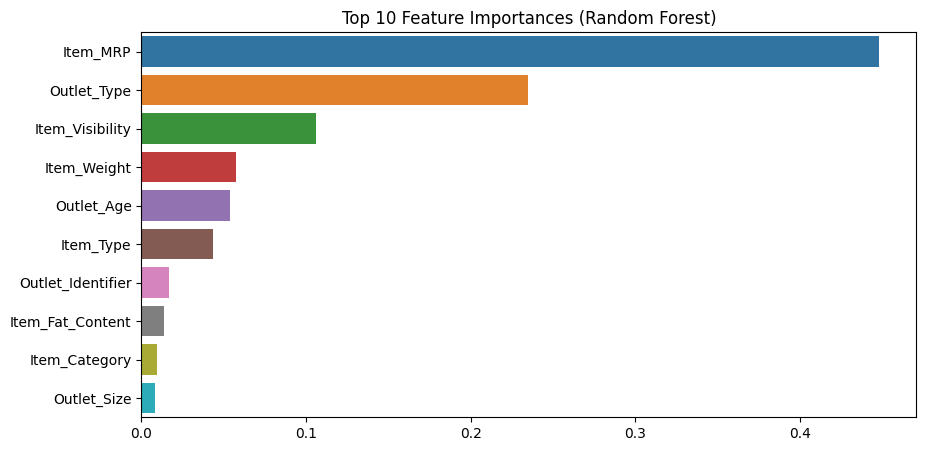

In [28]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()
top_features = feat_imp.index[:10].tolist()
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]


In [29]:

cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_params = {
    "iterations": [500, 800, 1000],
    "depth": [6, 7, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "bagging_temperature": [0, 1, 2, 5]
}
cat_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=cat_params,
    n_iter=15,  
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

cat_search.fit(X_train_top, y_train)

print("Best CatBoost Parameters:", cat_search.best_params_)
best_cat = cat_search.best_estimator_
y_pred_cat_tuned = best_cat.predict(X_val_top)

print("CatBoost (Top Features + Tuned) Performance:")
print("MAE:", mean_absolute_error(y_val, y_pred_cat_tuned))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_cat_tuned)))
print("R2:", r2_score(y_val, y_pred_cat_tuned))


Fitting 3 folds for each of 15 candidates, totalling 45 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits